# Translational invariance restoration
In this notebook we evaluate the solutions proposed by the literature, i.e., anti-aliasing and data augmentation, to restore translational invariance in CNNs in our use case of JPEG image analysis.  
We are then going to compare three variants of the various BondiNets:
1. Standard network;
2. Anti-Aliasing (AA) full and pool only;
3. Training a standard network with random crop data-augmentation.


## Libraries import

In [1]:
# Sys libraries
import os
import glob
import sys
sys.path.append('../')
from tqdm.notebook import tqdm

# Plotting libraries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
# SETTING THE PLOT parameters to the ACM font
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Linux Libertine O'
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{libertine}'
]

%matplotlib inline

# Torch and data libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import SubsetRandomSampler, SequentialSampler, DataLoader
from isplutils.data import CustomBlockJPEGBalancedDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
from architectures import fornet
from architectures.fornet import FeatureExtractor, create_model


/tmp/ipykernel_3671715/3055428795.py:18: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  mpl.rcParams['text.latex.preamble'] = [


## Helpers functions and classes

In [3]:
def bin_acc(y_pred, y_test) -> float:
    y_pred_sig = torch.sigmoid(y_pred)
    y_pred_tags = y_pred_sig > 0.5
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc *= 100
    return acc


def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.nn.functional.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc) * 100
    return acc


def batch_forward(net: torch.nn.Module, device, criterion,
                  data: torch.Tensor, labels: torch.Tensor) -> (torch.Tensor, float):
    if torch.cuda.is_available():
        data = data.to(device)
        labels = labels.to(device)
    out = net(data).squeeze()
    loss = criterion(out, labels)
    pred = torch.sigmoid(out)
    return loss, pred


def balanced_collate_fn(batch):
    return [torch.cat([elem[0] for elem in batch]), torch.cat([elem[1] for elem in batch])]


## Execution parameters

In [5]:
models_dir = '../models'
gpu_id = 2
precomputed = True  # whether to use the precomputed results or let the notebook do the job
data_root = '../data'  # PLACE HERE THE DIRECTORY WHERE YOU SAVED THE DATASETS!

### Let's build a Dataframe with all the models we need divided by stride

In [71]:
# Build the Dataframe
strides = [1, 2, 3, 4]
jpeg_blocks = [7, 8, 9, 12]
model_variants = ['BondiNetVS', 'AA-BondiNetVS full', 'AA-BondiNetVS pool only', 'BondiNetVS random crop']
all_models_df = pd.DataFrame(index=pd.MultiIndex.from_product([jpeg_blocks, strides, model_variants], 
                                                              names=['JPEG block size', 'Stride factor', 'Model variant']),
                            )
all_models_df['Model path'] = ''
for model_path in glob.glob(os.path.join(models_dir, '**/bestval.pth'), recursive=True):
    # Parse the parameters we need from the model path
    tag = model_path.split('/')[-2]
    net_class = tag.split('net-')[1].split('_')[0]
    if 'BondiNet' in net_class:
        random_crop = tag.split('random_crop-')[1].split('_')[0] == 'True'
        jpeg_bs = int(tag.split('jpeg_bs-')[1].split('_')[0])
        fl_stride = int(tag.split('fl_stride-')[1].split('_')[0])
        if net_class == 'AABondiNet':
            aa_pool = tag.split('aa_pool_only-')[1].split('/')[0] == 'True'
            if aa_pool:
                all_models_df.loc[(jpeg_bs, fl_stride, 'AA-BondiNetVS pool only'), 'Model path'] = model_path
            else:
                all_models_df.loc[(jpeg_bs, fl_stride, 'AA-BondiNetVS full'), 'Model path'] = model_path
        else:
            if random_crop:
                all_models_df.loc[(jpeg_bs, fl_stride, 'BondiNetVS random crop'), 'Model path'] = model_path
            else:
                all_models_df.loc[(jpeg_bs, fl_stride, 'BondiNetVS'), 'Model path'] = model_path

all_models_df

Model path
JPEG block size Stride factor Model variant                                                             
7               1             BondiNetVS               ../models/BondiNets/7x7_block_nets/net-BondiNe...
                              AA-BondiNetVS full                                                        
                              AA-BondiNetVS pool only                                                   
                              BondiNetVS random crop                                                    
                2             BondiNetVS               ../models/BondiNets/7x7_block_nets/net-BondiNe...
...                                                                                                  ...
12              3             BondiNetVS random crop   ../models/BondiNets_random_crop/12x12_block_ne...
                4             BondiNetVS               ../models/BondiNets/12x12_block_nets/net-Bondi...
                              AA-BondiNetVS full       ../models/AABondiNets/12x12_block_nets/net-AAB...
                              AA-BondiNetVS pool only  ../models/AABondiNets_pool_only/12x12_block_ne...
                              BondiNetVS random crop   ../models/BondiNets_random_crop/12x12_block_ne...

[64 rows x 1 columns]

## Before starting
**Please note** that the considered BondiNets are **already** translation invariant with respect to some JPEG images, e.g., on `7x7` samples all networks are translational invariant, on `8x8` the stride 1 and 3 networks are invariant, etc.  
Therefore, the most straightforward scenario to consider to evaluate the efficacy of anti-aliasing and data-augmentation is training and testing on `12x12` blocks JPEG images, since all the networks considered are only shiftable.  
Please note that similar results are valid for the other scenarios as well.

### 12x12 block JPEG images

In [72]:
block_size = 12
moi_df = all_models_df.loc[block_size]  # MOI = models of interest
moi_df

Model path
Stride factor Model variant                                                             
1             BondiNetVS               ../models/BondiNets/12x12_block_nets/net-Bondi...
              AA-BondiNetVS full                                                        
              AA-BondiNetVS pool only  ../models/AABondiNets_pool_only/12x12_block_ne...
              BondiNetVS random crop   ../models/BondiNets_random_crop/12x12_block_ne...
2             BondiNetVS               ../models/BondiNets/12x12_block_nets/net-Bondi...
              AA-BondiNetVS full       ../models/AABondiNets/12x12_block_nets/net-AAB...
              AA-BondiNetVS pool only  ../models/AABondiNets_pool_only/12x12_block_ne...
              BondiNetVS random crop   ../models/BondiNets_random_crop/12x12_block_ne...
3             BondiNetVS               ../models/BondiNets/12x12_block_nets/net-Bondi...
              AA-BondiNetVS full       ../models/AABondiNets/12x12_block_nets/net-AAB...
              AA-BondiNetVS pool only  ../models/AABondiNets_pool_only/12x12_block_ne...
              BondiNetVS random crop   ../models/BondiNets_random_crop/12x12_block_ne...
4             BondiNetVS               ../models/BondiNets/12x12_block_nets/net-Bondi...
              AA-BondiNetVS full       ../models/AABondiNets/12x12_block_nets/net-AAB...
              AA-BondiNetVS pool only  ../models/AABondiNets_pool_only/12x12_block_ne...
              BondiNetVS random crop   ../models/BondiNets_random_crop/12x12_block_ne...

In [78]:
all_stride_dfs = []

for stride in moi_df.index.get_level_values(0).unique():
    print(f'Doing networks with stride {stride} in the first layer...')
    
    # Create the displacement DF
    all_models_disp_df = []
    
    # Cycle over the models
    for i, r in moi_df.loc[stride].iterrows():
        
        # Extract the model path
        model_path = r['Model path']
        
        if len(model_path) == 0:
            continue
        
        # Displace along the diagonal direction
        test_dfs = dict()
        
        # Parse useful params from the model path
        split_seed = int(model_path.split('split_seed-')[1].split('_')[0])
        p_train_test = float(model_path.split('train_test-')[1].split('_')[0])
        p_train_val = float(model_path.split('train_val-')[1].split('_')[0])
        net_name = model_path.split('net-')[1].split('_')[0]
        in_channels = int(model_path.split('in_channels-')[1].split('_')[0])
        batch_size = 1
        fl_stride = int(model_path.split('fl_stride-')[1].split('_')[0])
        jpeg_bs = int(model_path.split('jpeg_bs-')[1].split('_')[0])
        patch_size = 64*fl_stride
        aa_pool_only = model_path.split('aa_pool_only-')[1].split('/')[0] == 'True' if 'AA' in model_path else None

        # Set the device
        device = f'cuda:{gpu_id}' if torch.cuda.is_available() else 'cpu'
        
        # Load net
        params = {'in_channels': in_channels, 'num_classes': 1, 'first_layer_stride': fl_stride,
                  'pool_only': aa_pool_only}
        net = create_model(net_name, params, device)
        net = net.eval()

        # load model
        print(f'Loading model {model_path}...')
        state_tmp = torch.load(model_path, map_location='cpu')
        if 'net' not in state_tmp.keys():
            state = OrderedDict({'net': OrderedDict()})
            [state['net'].update({'model.{}'.format(k): v}) for k, v in state_tmp.items()]
        else:
            state = state_tmp
        incomp_keys = net.load_state_dict(state['net'], strict=True)
        print(incomp_keys)
        print('Model loaded!')

        test_dfs = []
        for disp in range(jpeg_bs+1):

            # Load the data
            dataset = CustomBlockJPEGBalancedDataset(data_root=data_root, 
                                                     patch_size=patch_size, transforms=A.Compose([ToTensorV2()]),
                                                     grayscale=in_channels==1, disaligned_grid_patch=[disp, disp],
                                                     coherent_grid_patch=False if 'random_crop-True' in model_path else True,
                                                     jpeg_bs=jpeg_bs)
            
            # Split in training, validation and test
            dataset_idxs = list(range(len(dataset)))
            np.random.seed(split_seed)  # setting the seed for training-test split
            np.random.shuffle(dataset_idxs)
            test_split_index = int(np.floor((1 - p_train_test) * len(dataset)))
            train_val_idxs, test_idxs = dataset_idxs[test_split_index:], dataset_idxs[:test_split_index]
            val_split_index = int(np.floor((1 - p_train_val) * len(train_val_idxs)))
            train_idx, val_idx = train_val_idxs[val_split_index:], train_val_idxs[:val_split_index]
            
            # Take only test idx samples
            test_idxs = np.array(test_idxs)
            test_sampler = SequentialSampler(test_idxs)
            test_dl = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=4, shuffle=False, drop_last=False,
                                   sampler=test_sampler, collate_fn=balanced_collate_fn,)


            # --- TEST LOOP
            test_df = pd.DataFrame(index=np.arange(len(test_idxs)*2))
            test_df['bce_loss'] = 0.0
            test_df['pred'] = 0.0
            test_df['labels'] = False
            criterion = torch.nn.BCEWithLogitsLoss()
            test_loss = test_acc = test_num = 0
            for idx, batch_data in enumerate(tqdm(test_dl, desc='Test sample', leave=False, total=len(test_dl))):
                # Fetch data
                batch_img, batch_label = batch_data

                with torch.no_grad():
                    # Forward pass
                    batch_loss, batch_pred = batch_forward(net, device, criterion, batch_img, batch_label)
                    #batch_loss = batch_forward(net, device, criterion, batch_img, batch_label)

                # Save statistics
                test_df.loc[idx*2, 'bce_loss'] = batch_loss.detach().cpu().item()
                test_df.loc[idx*2, 'labels'] = batch_label[0].detach().cpu().item()>0
                test_df.loc[idx*2, 'pred'] = batch_pred[0].detach().cpu().item()
                test_df.loc[idx*2+1, 'bce_loss'] = batch_loss.detach().cpu().item()
                test_df.loc[idx*2+1, 'labels'] = batch_label[1].detach().cpu().item()>0
                test_df.loc[idx*2+1, 'pred'] = batch_pred[1].detach().cpu().item()


            # Clean GPU memory
            torch.cuda.empty_cache()

            # Save the results in the bigger dictionary
            test_dfs.append(pd.concat({disp: test_df.copy()}, names=['Grid displacement']))

        # Concatenate everything
        all_disps_df = pd.concat(test_dfs)
        all_models_disp_df.append(pd.concat({model_path: all_disps_df}, names=['Model']))
        
    all_stride_dfs.append(pd.concat({stride: pd.concat(all_models_disp_df)}, names=['Stride factor']))

# Concatenate everything
all_stride_dfs = pd.concat(all_stride_dfs)
all_stride_dfs

Doing networks with stride 1 in the first layer...
Loading model ../models/BondiNets/12x12_block_nets/net-BondiNet_lr-0.001_batch_size-32_split_train_test-0.75_split_train_val-0.75_split_seed-42_in_channels-1_init_period-10_jpeg_bs-12_fl_stride-1_grayscale-True_random_crop-False/bestval.pth...
<All keys matched successfully>
Model loaded!


/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Loading model ../models/AABondiNets_pool_only/12x12_block_nets/net-AABondiNet_lr-0.001_batch_size-32_split_train_test-0.75_split_train_val-0.75_split_seed-42_in_channels-1_init_period-10_jpeg_bs-12_fl_stride-1_grayscale-True_random_crop-False_aa_pool_only-True/bestval.pth...
<All keys matched successfully>
Model loaded!


/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Loading model ../models/BondiNets_random_crop/12x12_block_nets/net-BondiNet_lr-0.001_batch_size-32_split_train_test-0.75_split_train_val-0.75_split_seed-42_in_channels-1_init_period-10_jpeg_bs-12_fl_stride-1_grayscale-True_random_crop-True/bestval.pth...
<All keys matched successfully>
Model loaded!


/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Doing networks with stride 2 in the first layer...
Loading model ../models/BondiNets/12x12_block_nets/net-BondiNet_lr-0.001_batch_size-32_split_train_test-0.75_split_train_val-0.75_split_seed-42_in_channels-1_init_period-10_jpeg_bs-12_fl_stride-2_grayscale-True_random_crop-False/bestval.pth...
<All keys matched successfully>
Model loaded!


/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Loading model ../models/AABondiNets/12x12_block_nets/net-AABondiNet_lr-0.001_batch_size-32_split_train_test-0.75_split_train_val-0.75_split_seed-42_in_channels-1_init_period-10_jpeg_bs-12_fl_stride-2_grayscale-True_random_crop-False_aa_pool_only-False/bestval.pth...
<All keys matched successfully>
Model loaded!


/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Loading model ../models/AABondiNets_pool_only/12x12_block_nets/net-AABondiNet_lr-0.001_batch_size-32_split_train_test-0.75_split_train_val-0.75_split_seed-42_in_channels-1_init_period-10_jpeg_bs-12_fl_stride-2_grayscale-True_random_crop-False_aa_pool_only-True/bestval.pth...
<All keys matched successfully>
Model loaded!


/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Loading model ../models/BondiNets_random_crop/12x12_block_nets/net-BondiNet_lr-0.001_batch_size-32_split_train_test-0.75_split_train_val-0.75_split_seed-42_in_channels-1_init_period-10_jpeg_bs-12_fl_stride-2_grayscale-True_random_crop-True/bestval.pth...
<All keys matched successfully>
Model loaded!


/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Doing networks with stride 3 in the first layer...
Loading model ../models/BondiNets/12x12_block_nets/net-BondiNet_lr-0.001_batch_size-32_split_train_test-0.75_split_train_val-0.75_split_seed-42_in_channels-1_init_period-10_jpeg_bs-12_fl_stride-3_grayscale-True_random_crop-False/bestval.pth...
<All keys matched successfully>
Model loaded!


/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Loading model ../models/AABondiNets/12x12_block_nets/net-AABondiNet_lr-0.001_batch_size-32_split_train_test-0.75_split_train_val-0.75_split_seed-42_in_channels-1_init_period-10_jpeg_bs-12_fl_stride-3_grayscale-True_random_crop-False_aa_pool_only-False/bestval.pth...
<All keys matched successfully>
Model loaded!


/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Loading model ../models/AABondiNets_pool_only/12x12_block_nets/net-AABondiNet_lr-0.001_batch_size-32_split_train_test-0.75_split_train_val-0.75_split_seed-42_in_channels-1_init_period-10_jpeg_bs-12_fl_stride-3_grayscale-True_random_crop-False_aa_pool_only-True/bestval.pth...
<All keys matched successfully>
Model loaded!


/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Loading model ../models/BondiNets_random_crop/12x12_block_nets/net-BondiNet_lr-0.001_batch_size-32_split_train_test-0.75_split_train_val-0.75_split_seed-42_in_channels-1_init_period-10_jpeg_bs-12_fl_stride-3_grayscale-True_random_crop-True/bestval.pth...
<All keys matched successfully>
Model loaded!


/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Doing networks with stride 4 in the first layer...
Loading model ../models/BondiNets/12x12_block_nets/net-BondiNet_lr-0.001_batch_size-32_split_train_test-0.75_split_train_val-0.75_split_seed-42_in_channels-1_init_period-10_jpeg_bs-12_fl_stride-4_grayscale-True_random_crop-False/bestval.pth...
<All keys matched successfully>
Model loaded!


/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb91f7af8b0>
Traceback (most recent call last):
  File "/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():  File "/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb91f7af8b0>
Traceback (most recent call last):
  File "/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/nas/home

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Loading model ../models/AABondiNets/12x12_block_nets/net-AABondiNet_lr-0.001_batch_size-32_split_train_test-0.75_split_train_val-0.75_split_seed-42_in_channels-1_init_period-10_jpeg_bs-12_fl_stride-4_grayscale-True_random_crop-False_aa_pool_only-False/bestval.pth...
<All keys matched successfully>
Model loaded!


/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Loading model ../models/AABondiNets_pool_only/12x12_block_nets/net-AABondiNet_lr-0.001_batch_size-32_split_train_test-0.75_split_train_val-0.75_split_seed-42_in_channels-1_init_period-10_jpeg_bs-12_fl_stride-4_grayscale-True_random_crop-False_aa_pool_only-True/bestval.pth...
<All keys matched successfully>
Model loaded!


/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Loading model ../models/BondiNets_random_crop/12x12_block_nets/net-BondiNet_lr-0.001_batch_size-32_split_train_test-0.75_split_train_val-0.75_split_seed-42_in_channels-1_init_period-10_jpeg_bs-12_fl_stride-4_grayscale-True_random_crop-True/bestval.pth...
<All keys matched successfully>
Model loaded!


/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

bce_loss  \
Stride factor Model                                              Grid displacement                 
1             ../models/BondiNets/12x12_block_nets/net-BondiN... 0                 0    0.000000   
                                                                                   1    0.000000   
                                                                                   2    0.000209   
                                                                                   3    0.000209   
                                                                                   4    0.000016   
...                                                                                          ...   
4             ../models/BondiNets_random_crop/12x12_block_net... 12                663  0.000026   
                                                                                   664  0.000444   
                                                                                   665  0.000444   
                                                                                   666  0.002679   
                                                                                   667  0.002679   

                                                                                                pred  \
Stride factor Model                                              Grid displacement                     
1             ../models/BondiNets/12x12_block_nets/net-BondiN... 0                 0    8.371470e-09   
                                                                                   1    1.000000e+00   
                                                                                   2    9.389042e-07   
                                                                                   3    9.995822e-01   
                                                                                   4    6.133889e-07   
...                                                                                              ...   
4             ../models/BondiNets_random_crop/12x12_block_net... 12                663  1.000000e+00   
                                                                                   664  8.868724e-04   
                                                                                   665  9.999999e-01   
                                                                                   666  4.554503e-03   
                                                                                   667  9.992066e-01   

                                                                                        labels  
Stride factor Model                                              Grid displacement              
1             ../models/BondiNets/12x12_block_nets/net-BondiN... 0                 0     False  
                                                                                   1      True  
                                                                                   2     False  
                                                                                   3      True  
                                                                                   4     False  
...                                                                                        ...  
4             ../models/BondiNets_random_crop/12x12_block_net... 12                663    True  
                                                                                   664   False  
                                                                                   665    True  
                                                                                   666   False  
                                                                                   667    True  

[130260 rows x 3 columns]

### 1x1 stride networks

In [79]:
# Select the results
results_df = all_stride_dfs.loc[1]
results_df

bce_loss  \
Model                                              Grid displacement                 
../models/BondiNets/12x12_block_nets/net-BondiN... 0                 0    0.000000   
                                                                     1    0.000000   
                                                                     2    0.000209   
                                                                     3    0.000209   
                                                                     4    0.000016   
...                                                                            ...   
../models/BondiNets_random_crop/12x12_block_net... 12                663  0.000022   
                                                                     664  0.002509   
                                                                     665  0.002509   
                                                                     666  0.027088   
                                                                     667  0.027088   

                                                                                  pred  \
Model                                              Grid displacement                     
../models/BondiNets/12x12_block_nets/net-BondiN... 0                 0    8.371470e-09   
                                                                     1    1.000000e+00   
                                                                     2    9.389042e-07   
                                                                     3    9.995822e-01   
                                                                     4    6.133889e-07   
...                                                                                ...   
../models/BondiNets_random_crop/12x12_block_net... 12                663  9.999579e-01   
                                                                     664  3.239692e-05   
                                                                     665  9.950263e-01   
                                                                     666  1.641508e-03   
                                                                     667  9.488232e-01   

                                                                          labels  
Model                                              Grid displacement              
../models/BondiNets/12x12_block_nets/net-BondiN... 0                 0     False  
                                                                     1      True  
                                                                     2     False  
                                                                     3      True  
                                                                     4     False  
...                                                                          ...  
../models/BondiNets_random_crop/12x12_block_net... 12                663    True  
                                                                     664   False  
                                                                     665    True  
                                                                     666   False  
                                                                     667    True  

[26052 rows x 3 columns]

##### Absolute Score Difference (ADS)

/tmp/ipykernel_3671715/128720143.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  pred_df = results_df.loc[(model_path), 'pred']


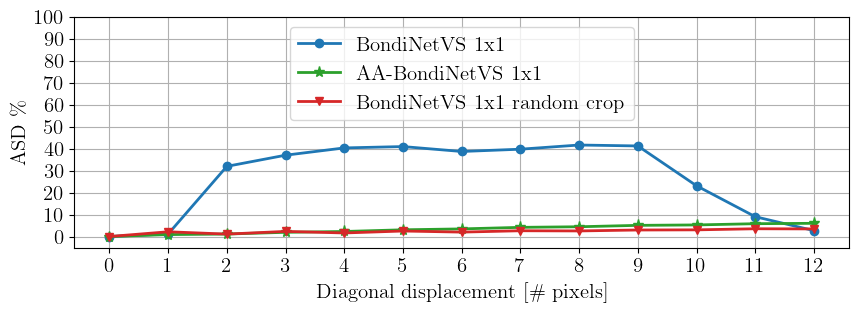

In [81]:
# Prepare plot
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
fontsize=20
markers = ['o', '*', 'v', '^']
color_maps = {'BondiNetVS': '#1f77b4', 'AA-BondiNetVS pool only': '#ff7f0e', 
              'AA-BondiNetVS': '#2ca02c', 'BondiNetVS random crop': '#d62728'}
for idx, model_path in enumerate(results_df.index.get_level_values(0).unique()):
    fl_stride = int(model_path.split('fl_stride-')[1].split('_')[0])
    net_name = model_path.split('net-')[1].split('_')[0]
    if net_name == 'BondiNet':
        label = f'BondiNetVS {fl_stride}x{fl_stride} random crop' if 'random_crop-True' in model_path else f'BondiNetVS {fl_stride}x{fl_stride}'
        color = color_maps['BondiNetVS random crop'] if 'random_crop-True' in model_path else color_maps['BondiNetVS']
    else:
        label = f'AA-BondiNetVS {fl_stride}x{fl_stride}'
        color = color_maps['AA-BondiNetVS']
    pred_df = results_df.loc[(model_path), 'pred']
    differences = []
    for disp in range(int(jpeg_bs)+1):
        differences.append(np.mean(np.abs(pred_df.loc[disp].to_numpy() - pred_df.loc[0].to_numpy()))*100)
    if markers[idx] == '*':
        axs.plot(differences, label=label, marker=markers[idx], linewidth=2, markersize=8, color=color)
    else:
        axs.plot(differences, label=label, marker=markers[idx], linewidth=2, markersize=6, color=color)
axs.legend(fontsize=fontsize-5, ncols=1, loc='upper center')
axs.set_ylabel(r'ASD \%', fontsize=fontsize-5)
axs.tick_params('both', labelsize=fontsize-5)
axs.set_xlabel(r'Diagonal displacement [\# pixels]', fontsize=fontsize-5)
axs.grid('on')
axs.set_ylim([-5, 100])
axs.set_yticks(np.arange(0, 110, 10))
axs.set_xticks(np.arange(int(jpeg_bs)+1))
plt.show()

##### BCE loss

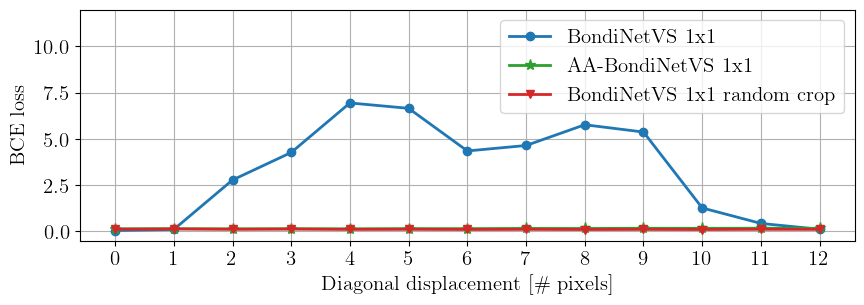

In [88]:
# Prepare plot
fontsize=20
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
markers = ['o', '*', 'v', '^']
color_maps = {'BondiNetVS': '#1f77b4', 'AA-BondiNetVS pool only': '#ff7f0e', 
              'AA-BondiNetVS': '#2ca02c', 'BondiNetVS random crop': '#d62728'}
for idx, model_path in enumerate(results_df.index.get_level_values(0).unique()):
    fl_stride = int(model_path.split('fl_stride-')[1].split('_')[0])
    net_name = model_path.split('net-')[1].split('_')[0]
    if net_name == 'BondiNet':
        label = f'BondiNetVS {fl_stride}x{fl_stride} random crop' if 'random_crop-True' in model_path else f'BondiNetVS {fl_stride}x{fl_stride}'
        color = color_maps['BondiNetVS random crop'] if 'random_crop-True' in model_path else color_maps['BondiNetVS']
    else:
        label = f'AA-BondiNetVS {fl_stride}x{fl_stride}'
        color = color_maps['AA-BondiNetVS']
    test_df = results_df.loc[(model_path)]
    mean_df = test_df.groupby('Grid displacement').mean()
    marker_size = 8 if markers[idx] == '*' else 6
    axs.plot(mean_df['bce_loss'], label=label, marker=markers[idx], markersize=marker_size, linewidth=2,
            color=color)
axs.legend(fontsize=fontsize-5)
axs.set_ylabel(r'BCE loss', fontsize=fontsize-5)
axs.tick_params('both', labelsize=fontsize-5)
axs.set_xlabel(r'Diagonal displacement [\# pixels]', fontsize=fontsize-5)
axs.grid('on')
axs.set_ylim([-0.5, 12])
axs.set_xticks(np.arange(int(jpeg_bs)+1))
plt.show()

#### 2x2 stride networks

In [89]:
# Select the results
results_df = all_stride_dfs.loc[2]
results_df

bce_loss  \
Model                                              Grid displacement                 
../models/BondiNets/12x12_block_nets/net-BondiN... 0                 0    0.005947   
                                                                     1    0.005947   
                                                                     2    0.074158   
                                                                     3    0.074158   
                                                                     4    0.001010   
...                                                                            ...   
../models/BondiNets_random_crop/12x12_block_net... 12                663  0.000000   
                                                                     664  0.000102   
                                                                     665  0.000102   
                                                                     666  0.000323   
                                                                     667  0.000323   

                                                                              pred  \
Model                                              Grid displacement                 
../models/BondiNets/12x12_block_nets/net-BondiN... 0                 0    0.000006   
                                                                     1    0.988184   
                                                                     2    0.129553   
                                                                     3    0.990478   
                                                                     4    0.000021   
...                                                                            ...   
../models/BondiNets_random_crop/12x12_block_net... 12                663  1.000000   
                                                                     664  0.000080   
                                                                     665  0.999876   
                                                                     666  0.000264   
                                                                     667  0.999619   

                                                                          labels  
Model                                              Grid displacement              
../models/BondiNets/12x12_block_nets/net-BondiN... 0                 0     False  
                                                                     1      True  
                                                                     2     False  
                                                                     3      True  
                                                                     4     False  
...                                                                          ...  
../models/BondiNets_random_crop/12x12_block_net... 12                663    True  
                                                                     664   False  
                                                                     665    True  
                                                                     666   False  
                                                                     667    True  

[34736 rows x 3 columns]

##### Absolute Score Difference (ASD)

/tmp/ipykernel_3671715/3432697340.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  pred_df = results_df.loc[(model_path), 'pred']


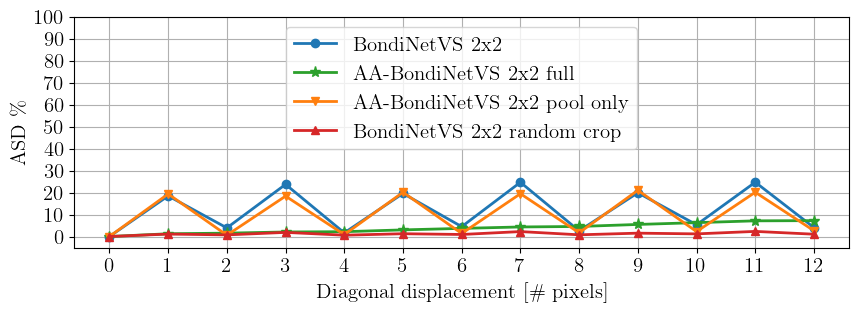

In [91]:
# Prepare plot
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
fontsize=20
markers = ['o', '*', 'v', '^']
color_maps = {'BondiNetVS': '#1f77b4', 'AA-BondiNetVS pool only': '#ff7f0e', 
              'AA-BondiNetVS': '#2ca02c', 'BondiNetVS random crop': '#d62728'}
for idx, model_path in enumerate(results_df.index.get_level_values(0).unique()):
    fl_stride = int(model_path.split('fl_stride-')[1].split('_')[0])
    net_name = model_path.split('net-')[1].split('_')[0]
    if net_name == 'BondiNet':
        label = f'BondiNetVS {fl_stride}x{fl_stride} random crop' if 'random_crop-True' in model_path else f'BondiNetVS {fl_stride}x{fl_stride}'
        color = color_maps['BondiNetVS random crop'] if 'random_crop-True' in model_path else color_maps['BondiNetVS']
    else:
        label = f'AA-BondiNetVS {fl_stride}x{fl_stride}'
        if 'pool_only-False' in model_path:
            label += ' full'
            color = color_maps['AA-BondiNetVS']
        else:
            label += ' pool only'
            color = color_maps['AA-BondiNetVS pool only']
    pred_df = results_df.loc[(model_path), 'pred']
    differences = []
    for disp in range(int(jpeg_bs)+1):
        differences.append(np.mean(np.abs(pred_df.loc[disp].to_numpy() - pred_df.loc[0].to_numpy()))*100)
    if markers[idx] == '*':
        axs.plot(differences, label=label, marker=markers[idx], linewidth=2, markersize=8, color=color)
    else:
        axs.plot(differences, label=label, marker=markers[idx], linewidth=2, markersize=6, color=color)
axs.legend(fontsize=fontsize-5, ncols=1, loc='upper center')
axs.set_ylabel(r'ASD \%', fontsize=fontsize-5)
axs.tick_params('both', labelsize=fontsize-5)
axs.set_xlabel(r'Diagonal displacement [\# pixels]', fontsize=fontsize-5)
axs.grid('on')
axs.set_ylim([-5, 100])
axs.set_yticks(np.arange(0, 110, 10))
axs.set_xticks(np.arange(int(jpeg_bs)+1))
plt.show()

##### BCE loss

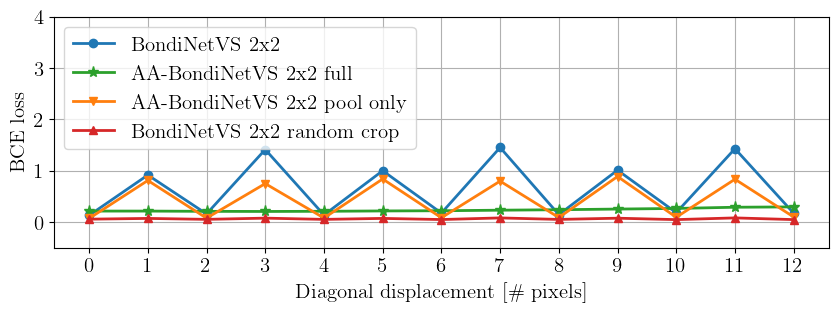

In [95]:
# Prepare plot
fontsize=20
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
markers = ['o', '*', 'v', '^']
color_maps = {'BondiNetVS': '#1f77b4', 'AA-BondiNetVS pool only': '#ff7f0e', 
              'AA-BondiNetVS': '#2ca02c', 'BondiNetVS random crop': '#d62728'}
for idx, model_path in enumerate(results_df.index.get_level_values(0).unique()):
    fl_stride = int(model_path.split('fl_stride-')[1].split('_')[0])
    net_name = model_path.split('net-')[1].split('_')[0]
    if net_name == 'BondiNet':
        label = f'BondiNetVS {fl_stride}x{fl_stride} random crop' if 'random_crop-True' in model_path else f'BondiNetVS {fl_stride}x{fl_stride}'
        color = color_maps['BondiNetVS random crop'] if 'random_crop-True' in model_path else color_maps['BondiNetVS']
    else:
        label = f'AA-BondiNetVS {fl_stride}x{fl_stride}'
        if 'pool_only-False' in model_path:
            label += ' full'
            color = color_maps['AA-BondiNetVS']
        else:
            label += ' pool only'
            color = color_maps['AA-BondiNetVS pool only']
    test_df = results_df.loc[(model_path)]
    mean_df = test_df.groupby('Grid displacement').mean()
    marker_size = 8 if markers[idx] == '*' else 6
    axs.plot(mean_df['bce_loss'], label=label, marker=markers[idx], markersize=marker_size, linewidth=2,
            color=color)
axs.legend(fontsize=fontsize-5)
axs.set_ylabel(r'BCE loss', fontsize=fontsize-5)
axs.tick_params('both', labelsize=fontsize-5)
axs.set_xlabel(r'Diagonal displacement [\# pixels]', fontsize=fontsize-5)
axs.grid('on')
axs.set_ylim([-0.5, 4])
axs.set_xticks(np.arange(int(jpeg_bs)+1))
plt.show()

#### 3x3 stride networks

In [96]:
# Select the results
results_df = all_stride_dfs.loc[3]
results_df

bce_loss  \
Model                                              Grid displacement                 
../models/BondiNets/12x12_block_nets/net-BondiN... 0                 0    0.000117   
                                                                     1    0.000117   
                                                                     2    0.000003   
                                                                     3    0.000003   
                                                                     4    0.000087   
...                                                                            ...   
../models/BondiNets_random_crop/12x12_block_net... 12                663  0.000042   
                                                                     664  0.001514   
                                                                     665  0.001514   
                                                                     666  0.005451   
                                                                     667  0.005451   

                                                                                  pred  \
Model                                              Grid displacement                     
../models/BondiNets/12x12_block_nets/net-BondiN... 0                 0    1.334154e-04   
                                                                     1    9.999000e-01   
                                                                     2    7.253739e-09   
                                                                     3    9.999940e-01   
                                                                     4    2.344525e-05   
...                                                                                ...   
../models/BondiNets_random_crop/12x12_block_net... 12                663  9.999151e-01   
                                                                     664  8.028135e-04   
                                                                     665  9.977768e-01   
                                                                     666  1.082206e-02   
                                                                     667  9.999782e-01   

                                                                          labels  
Model                                              Grid displacement              
../models/BondiNets/12x12_block_nets/net-BondiN... 0                 0     False  
                                                                     1      True  
                                                                     2     False  
                                                                     3      True  
                                                                     4     False  
...                                                                          ...  
../models/BondiNets_random_crop/12x12_block_net... 12                663    True  
                                                                     664   False  
                                                                     665    True  
                                                                     666   False  
                                                                     667    True  

[34736 rows x 3 columns]

##### Absolute Score Difference (ASD)

/tmp/ipykernel_3671715/3284426042.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  pred_df = results_df.loc[(model_path), 'pred']


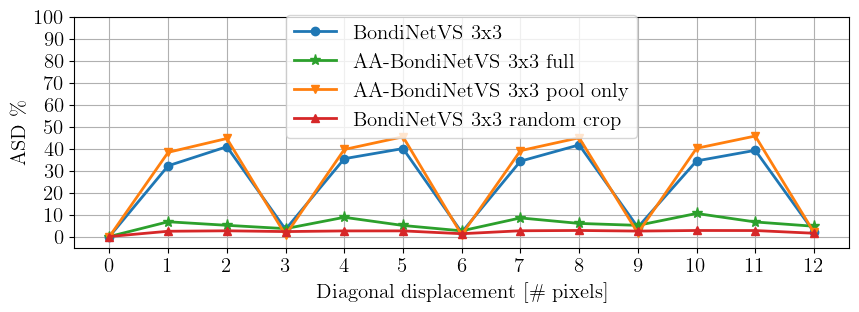

In [102]:
# Prepare plot
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
fontsize=20
markers = ['o', '*', 'v', '^']
color_maps = {'BondiNetVS': '#1f77b4', 'AA-BondiNetVS pool only': '#ff7f0e', 
              'AA-BondiNetVS': '#2ca02c', 'BondiNetVS random crop': '#d62728'}
for idx, model_path in enumerate(results_df.index.get_level_values(0).unique()):
    fl_stride = int(model_path.split('fl_stride-')[1].split('_')[0])
    net_name = model_path.split('net-')[1].split('_')[0]
    if net_name == 'BondiNet':
        label = f'BondiNetVS {fl_stride}x{fl_stride} random crop' if 'random_crop-True' in model_path else f'BondiNetVS {fl_stride}x{fl_stride}'
        color = color_maps['BondiNetVS random crop'] if 'random_crop-True' in model_path else color_maps['BondiNetVS']
    else:
        label = f'AA-BondiNetVS {fl_stride}x{fl_stride}'
        if 'pool_only-False' in model_path:
            label += ' full'
            color = color_maps['AA-BondiNetVS']
        else:
            label += ' pool only'
            color = color_maps['AA-BondiNetVS pool only']
    pred_df = results_df.loc[(model_path), 'pred']
    differences = []
    for disp in range(int(jpeg_bs)+1):
        differences.append(np.mean(np.abs(pred_df.loc[disp].to_numpy() - pred_df.loc[0].to_numpy()))*100)
    if markers[idx] == '*':
        axs.plot(differences, label=label, marker=markers[idx], linewidth=2, markersize=8, color=color)
    else:
        axs.plot(differences, label=label, marker=markers[idx], linewidth=2, markersize=6, color=color)
axs.legend(fontsize=fontsize-5, ncols=1, loc='upper center', bbox_to_anchor=(0.5, 1.05))
axs.set_ylabel(r'ASD \%', fontsize=fontsize-5)
axs.tick_params('both', labelsize=fontsize-5)
axs.set_xlabel(r'Diagonal displacement [\# pixels]', fontsize=fontsize-5)
axs.grid('on')
axs.set_ylim([-5, 100])
axs.set_yticks(np.arange(0, 110, 10))
axs.set_xticks(np.arange(int(jpeg_bs)+1))
plt.show()

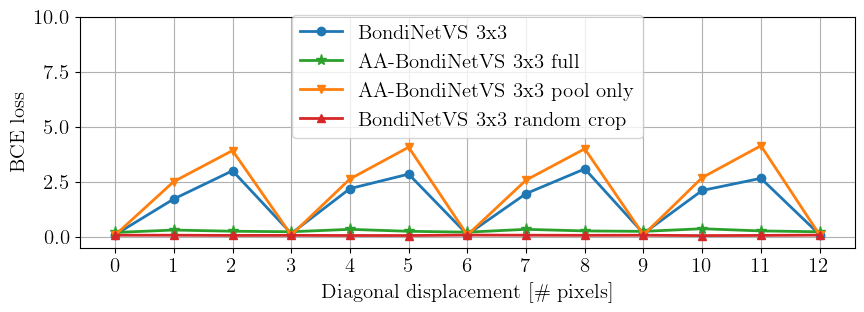

In [103]:
# Prepare plot
fontsize=20
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
markers = ['o', '*', 'v', '^']
color_maps = {'BondiNetVS': '#1f77b4', 'AA-BondiNetVS pool only': '#ff7f0e', 
              'AA-BondiNetVS': '#2ca02c', 'BondiNetVS random crop': '#d62728'}
for idx, model_path in enumerate(results_df.index.get_level_values(0).unique()):
    fl_stride = int(model_path.split('fl_stride-')[1].split('_')[0])
    net_name = model_path.split('net-')[1].split('_')[0]
    if net_name == 'BondiNet':
        label = f'BondiNetVS {fl_stride}x{fl_stride} random crop' if 'random_crop-True' in model_path else f'BondiNetVS {fl_stride}x{fl_stride}'
        color = color_maps['BondiNetVS random crop'] if 'random_crop-True' in model_path else color_maps['BondiNetVS']
    else:
        label = f'AA-BondiNetVS {fl_stride}x{fl_stride}'
        if 'pool_only-False' in model_path:
            label += ' full'
            color = color_maps['AA-BondiNetVS']
        else:
            label += ' pool only'
            color = color_maps['AA-BondiNetVS pool only']
    test_df = results_df.loc[(model_path)]
    mean_df = test_df.groupby('Grid displacement').mean()
    marker_size = 8 if markers[idx] == '*' else 6
    axs.plot(mean_df['bce_loss'], label=label, marker=markers[idx], markersize=marker_size, linewidth=2,
            color=color)
axs.legend(fontsize=fontsize-5, ncols=1, loc='upper center', bbox_to_anchor=(0.5, 1.05))
axs.set_ylabel(r'BCE loss', fontsize=fontsize-5)
axs.tick_params('both', labelsize=fontsize-5)
axs.set_xlabel(r'Diagonal displacement [\# pixels]', fontsize=fontsize-5)
axs.grid('on')
axs.set_ylim([-0.5, 10])
axs.set_xticks(np.arange(int(jpeg_bs)+1))
plt.show()

#### 4x4 stride networks

In [104]:
# Select the results
results_df = all_stride_dfs.loc[4]
results_df

bce_loss  \
Model                                              Grid displacement                     
../models/BondiNets/12x12_block_nets/net-BondiN... 0                 0    3.576278e-07   
                                                                     1    3.576278e-07   
                                                                     2    5.960464e-08   
                                                                     3    5.960464e-08   
                                                                     4    2.088055e-03   
...                                                                                ...   
../models/BondiNets_random_crop/12x12_block_net... 12                663  2.610615e-05   
                                                                     664  4.436789e-04   
                                                                     665  4.436789e-04   
                                                                     666  2.679337e-03   
                                                                     667  2.679337e-03   

                                                                                  pred  \
Model                                              Grid displacement                     
../models/BondiNets/12x12_block_nets/net-BondiN... 0                 0    6.444982e-07   
                                                                     1    9.999999e-01   
                                                                     2    7.431625e-08   
                                                                     3    1.000000e+00   
                                                                     4    4.167297e-03   
...                                                                                ...   
../models/BondiNets_random_crop/12x12_block_net... 12                663  1.000000e+00   
                                                                     664  8.868724e-04   
                                                                     665  9.999999e-01   
                                                                     666  4.554503e-03   
                                                                     667  9.992066e-01   

                                                                          labels  
Model                                              Grid displacement              
../models/BondiNets/12x12_block_nets/net-BondiN... 0                 0     False  
                                                                     1      True  
                                                                     2     False  
                                                                     3      True  
                                                                     4     False  
...                                                                          ...  
../models/BondiNets_random_crop/12x12_block_net... 12                663    True  
                                                                     664   False  
                                                                     665    True  
                                                                     666   False  
                                                                     667    True  

[34736 rows x 3 columns]

##### Absolute Score Difference (ASD)

/tmp/ipykernel_3671715/1668412918.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  pred_df = results_df.loc[(model_path), 'pred']


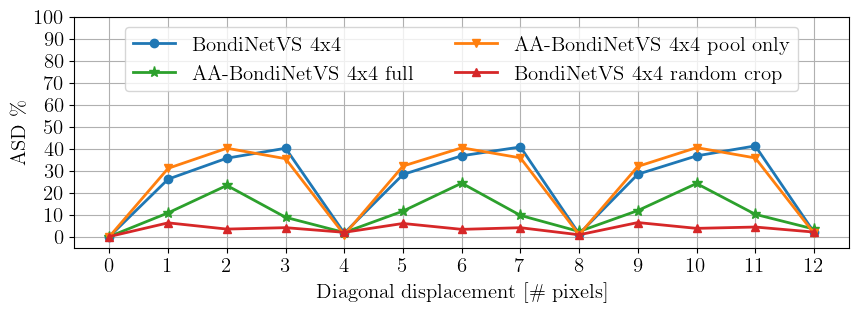

In [105]:
# Prepare plot
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
fontsize=20
markers = ['o', '*', 'v', '^']
color_maps = {'BondiNetVS': '#1f77b4', 'AA-BondiNetVS pool only': '#ff7f0e', 
              'AA-BondiNetVS': '#2ca02c', 'BondiNetVS random crop': '#d62728'}
for idx, model_path in enumerate(results_df.index.get_level_values(0).unique()):
    fl_stride = int(model_path.split('fl_stride-')[1].split('_')[0])
    net_name = model_path.split('net-')[1].split('_')[0]
    if net_name == 'BondiNet':
        label = f'BondiNetVS {fl_stride}x{fl_stride} random crop' if 'random_crop-True' in model_path else f'BondiNetVS {fl_stride}x{fl_stride}'
        color = color_maps['BondiNetVS random crop'] if 'random_crop-True' in model_path else color_maps['BondiNetVS']
    else:
        label = f'AA-BondiNetVS {fl_stride}x{fl_stride}'
        if 'pool_only-False' in model_path:
            label += ' full'
            color = color_maps['AA-BondiNetVS']
        else:
            label += ' pool only'
            color = color_maps['AA-BondiNetVS pool only']
    pred_df = results_df.loc[(model_path), 'pred']
    differences = []
    for disp in range(int(jpeg_bs)+1):
        differences.append(np.mean(np.abs(pred_df.loc[disp].to_numpy() - pred_df.loc[0].to_numpy()))*100)
    if markers[idx] == '*':
        axs.plot(differences, label=label, marker=markers[idx], linewidth=2, markersize=8, color=color)
    else:
        axs.plot(differences, label=label, marker=markers[idx], linewidth=2, markersize=6, color=color)
axs.legend(fontsize=fontsize-5, ncols=2, loc='upper center')
axs.set_ylabel(r'ASD \%', fontsize=fontsize-5)
axs.tick_params('both', labelsize=fontsize-5)
axs.set_xlabel(r'Diagonal displacement [\# pixels]', fontsize=fontsize-5)
axs.grid('on')
axs.set_ylim([-5, 100])
axs.set_yticks(np.arange(0, 110, 10))
axs.set_xticks(np.arange(int(jpeg_bs)+1))
plt.show()

##### BCE loss

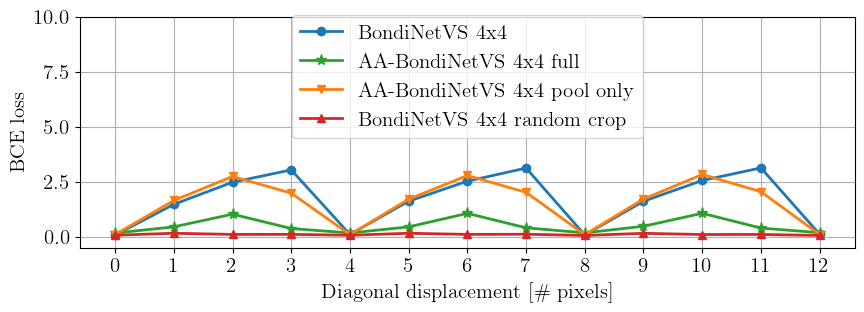

In [106]:
# Prepare plot
fontsize=20
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
markers = ['o', '*', 'v', '^']
color_maps = {'BondiNetVS': '#1f77b4', 'AA-BondiNetVS pool only': '#ff7f0e', 
              'AA-BondiNetVS': '#2ca02c', 'BondiNetVS random crop': '#d62728'}
for idx, model_path in enumerate(results_df.index.get_level_values(0).unique()):
    fl_stride = int(model_path.split('fl_stride-')[1].split('_')[0])
    net_name = model_path.split('net-')[1].split('_')[0]
    if net_name == 'BondiNet':
        label = f'BondiNetVS {fl_stride}x{fl_stride} random crop' if 'random_crop-True' in model_path else f'BondiNetVS {fl_stride}x{fl_stride}'
        color = color_maps['BondiNetVS random crop'] if 'random_crop-True' in model_path else color_maps['BondiNetVS']
    else:
        label = f'AA-BondiNetVS {fl_stride}x{fl_stride}'
        if 'pool_only-False' in model_path:
            label += ' full'
            color = color_maps['AA-BondiNetVS']
        else:
            label += ' pool only'
            color = color_maps['AA-BondiNetVS pool only']
    test_df = results_df.loc[(model_path)]
    mean_df = test_df.groupby('Grid displacement').mean()
    marker_size = 8 if markers[idx] == '*' else 6
    axs.plot(mean_df['bce_loss'], label=label, marker=markers[idx], markersize=marker_size, linewidth=2,
            color=color)
axs.legend(fontsize=fontsize-5, loc='upper center', bbox_to_anchor=(0.5, 1.05))
axs.set_ylabel(r'BCE loss', fontsize=fontsize-5)
axs.tick_params('both', labelsize=fontsize-5)
axs.set_xlabel(r'Diagonal displacement [\# pixels]', fontsize=fontsize-5)
axs.grid('on')
axs.set_ylim([-0.5, 10])
axs.set_xticks(np.arange(int(jpeg_bs)+1))
plt.show()

## Credits
[Image and Sound Processing Lab (ISPL)](http://ispl.deib.polimi.it/)
- Edoardo Daniele Cannas;
- Sara Mandelli;
- Paolo Bestagini;
- Stefano Tubaro.